In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from scipy.special import rel_entr
from scipy.stats import entropy
import scipy.stats
import math
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
! nvidia-smi

Tue Aug  2 16:56:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 73%   84C    P2   168W / 260W |   5747MiB / 11019MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 32%   

# MongoDB

In [4]:
from pymongo import MongoClient
import pymongo

In [5]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_rm_us = db.rm_patent_us
    # db_rm_cn = db.rm_patent_cn
    # db_rm_de = db.rm_patent_de
    
    # db_rm_us_2015 = db.rm_patent_us_2015
    db_rm_cn_2015 = db.rm_patent_cn_2015
    # db_rm_de_2015 = db.rm_patent_de_2015
except errors.ConnectionFailure as err:
    print(err)

# 2015

## Company數量

In [6]:
data_assignee = db_rm_cn_2015.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_cn = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [7]:
# 取總數前15家公司
# final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
df_family_cn.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(16)

,company,count
0,Chengdu Qinchuan IoT Technology Co Ltd,82
19,SUZHOU XUANHE IOT TECHNOLOGY Co Ltd,81
10,Jiangsu IoT Research and Development Center,61
13,Nanjing Hansense Iot Technology Co Ltd,26
14,Nanjing IoT Sensor Technology Co Ltd,25
4,GUANGDONG ABEJ IOT INTELLIGENT TECHNOLOGY Co Ltd,24
7,Huawei Technologies Co Ltd,19
20,Samsung Electronics Co Ltd,17
17,SHENZHEN QIANHAI LINGJU INTERNET OF THINGS SCI...,16
22,Shenzhen Qianhai Livall IoT Technology Co Ltd,16


In [8]:
# com_df = final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
com_df = df_family_cn.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
com_df.reset_index(drop=True, inplace=True)

In [9]:
com_df["count_log"] = com_df["count"].apply(lambda x: np.log(x))
com_df

,company,count,count_log
0,Chengdu Qinchuan IoT Technology Co Ltd,82,4.406719
1,SUZHOU XUANHE IOT TECHNOLOGY Co Ltd,81,4.394449
2,Jiangsu IoT Research and Development Center,61,4.110874
3,Nanjing Hansense Iot Technology Co Ltd,26,3.258097
4,Nanjing IoT Sensor Technology Co Ltd,25,3.218876
5,GUANGDONG ABEJ IOT INTELLIGENT TECHNOLOGY Co Ltd,24,3.178054
6,Huawei Technologies Co Ltd,19,2.944439
7,Samsung Electronics Co Ltd,17,2.833213
8,SHENZHEN QIANHAI LINGJU INTERNET OF THINGS SCI...,16,2.772589
9,Shenzhen Qianhai Livall IoT Technology Co Ltd,16,2.772589


In [10]:
com_ls = list(com_df.company)

## Data

In [11]:
ccontry = pd.read_csv("../patent/code/依年分/rm_company_country_cn_2015.csv")
ccpc = pd.read_csv("../LDA/company_lda_brief_cn_2015.csv")

In [12]:
ccontry[ccontry.company.isin(com_ls)]

,company,AP,AR,AU,BR,CA,CL,CN,CO,DE,...,PL,PT,RU,SA,SG,SI,TN,TW,US,UY
69,Chengdu Qinchuan IoT Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,82.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
94,Chongqing Liuhe Iot Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138,GUANGDONG ABEJ IOT INTELLIGENT TECHNOLOGY Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,Huawei Technologies Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0
201,Huizhou Sanhe Iot Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
229,Jiangsu IoT Research and Development Center,0.0,0.0,0.0,0.0,0.0,0.0,75.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
263,Mangoiot Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
283,Nanjing Hansense Iot Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
285,Nanjing IoT Sensor Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
350,SHENZHEN QIANHAI LINGJU INTERNET OF THINGS SCI...,0.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


## Similarity計算

### Country

- 換成機率  

In [13]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

### PBC
- 和Samsung Electronics Co Ltd比較

In [14]:
ccontry_pbc = ccontry2.loc[com_ls,:].copy()
ccontry_pbc.head()

,AP,AR,AU,BR,CA,CL,CN,CO,DE,DK,...,PL,PT,RU,SA,SG,SI,TN,TW,US,UY
company,,,,,,,,,,,,,,,,,,,,,
Chengdu Qinchuan IoT Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.964706,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011765,0.0
SUZHOU XUANHE IOT TECHNOLOGY Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
Jiangsu IoT Research and Development Center,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
Nanjing Hansense Iot Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
Nanjing IoT Sensor Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [15]:
def PBC(a,b):
    return sum(a*b)

ccontry_pbc["sum"] = ccontry_pbc.apply(lambda x: PBC(ccontry_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

### CPC

In [16]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [17]:
ccpc_pbc = ccpc2.loc[com_ls,:].copy()
# ccpc_pbc

In [18]:
def PBC(a,b):
    return sum(a*b)

ccpc_pbc["sum"] = ccpc_pbc.apply(lambda x: PBC(ccpc_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

## Scatter Plot

In [19]:
# loop test
def scatter_plot(pbc_n,cpc_n):
    # PBC
    pbc_ls=[]
    n = pbc_n
    for i in ccontry_pbc.index:
        pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccontry_pbc["pbc"]=pbc_ls
    
    # CPC
    pbc_ls=[]
    n = cpc_n
    for i in ccpc_pbc.index:
        pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccpc_pbc["pbc"]=pbc_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pbc["pbc"]), list(ccontry_pbc["pbc"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pbc.index, inplace=True)

    return c_df

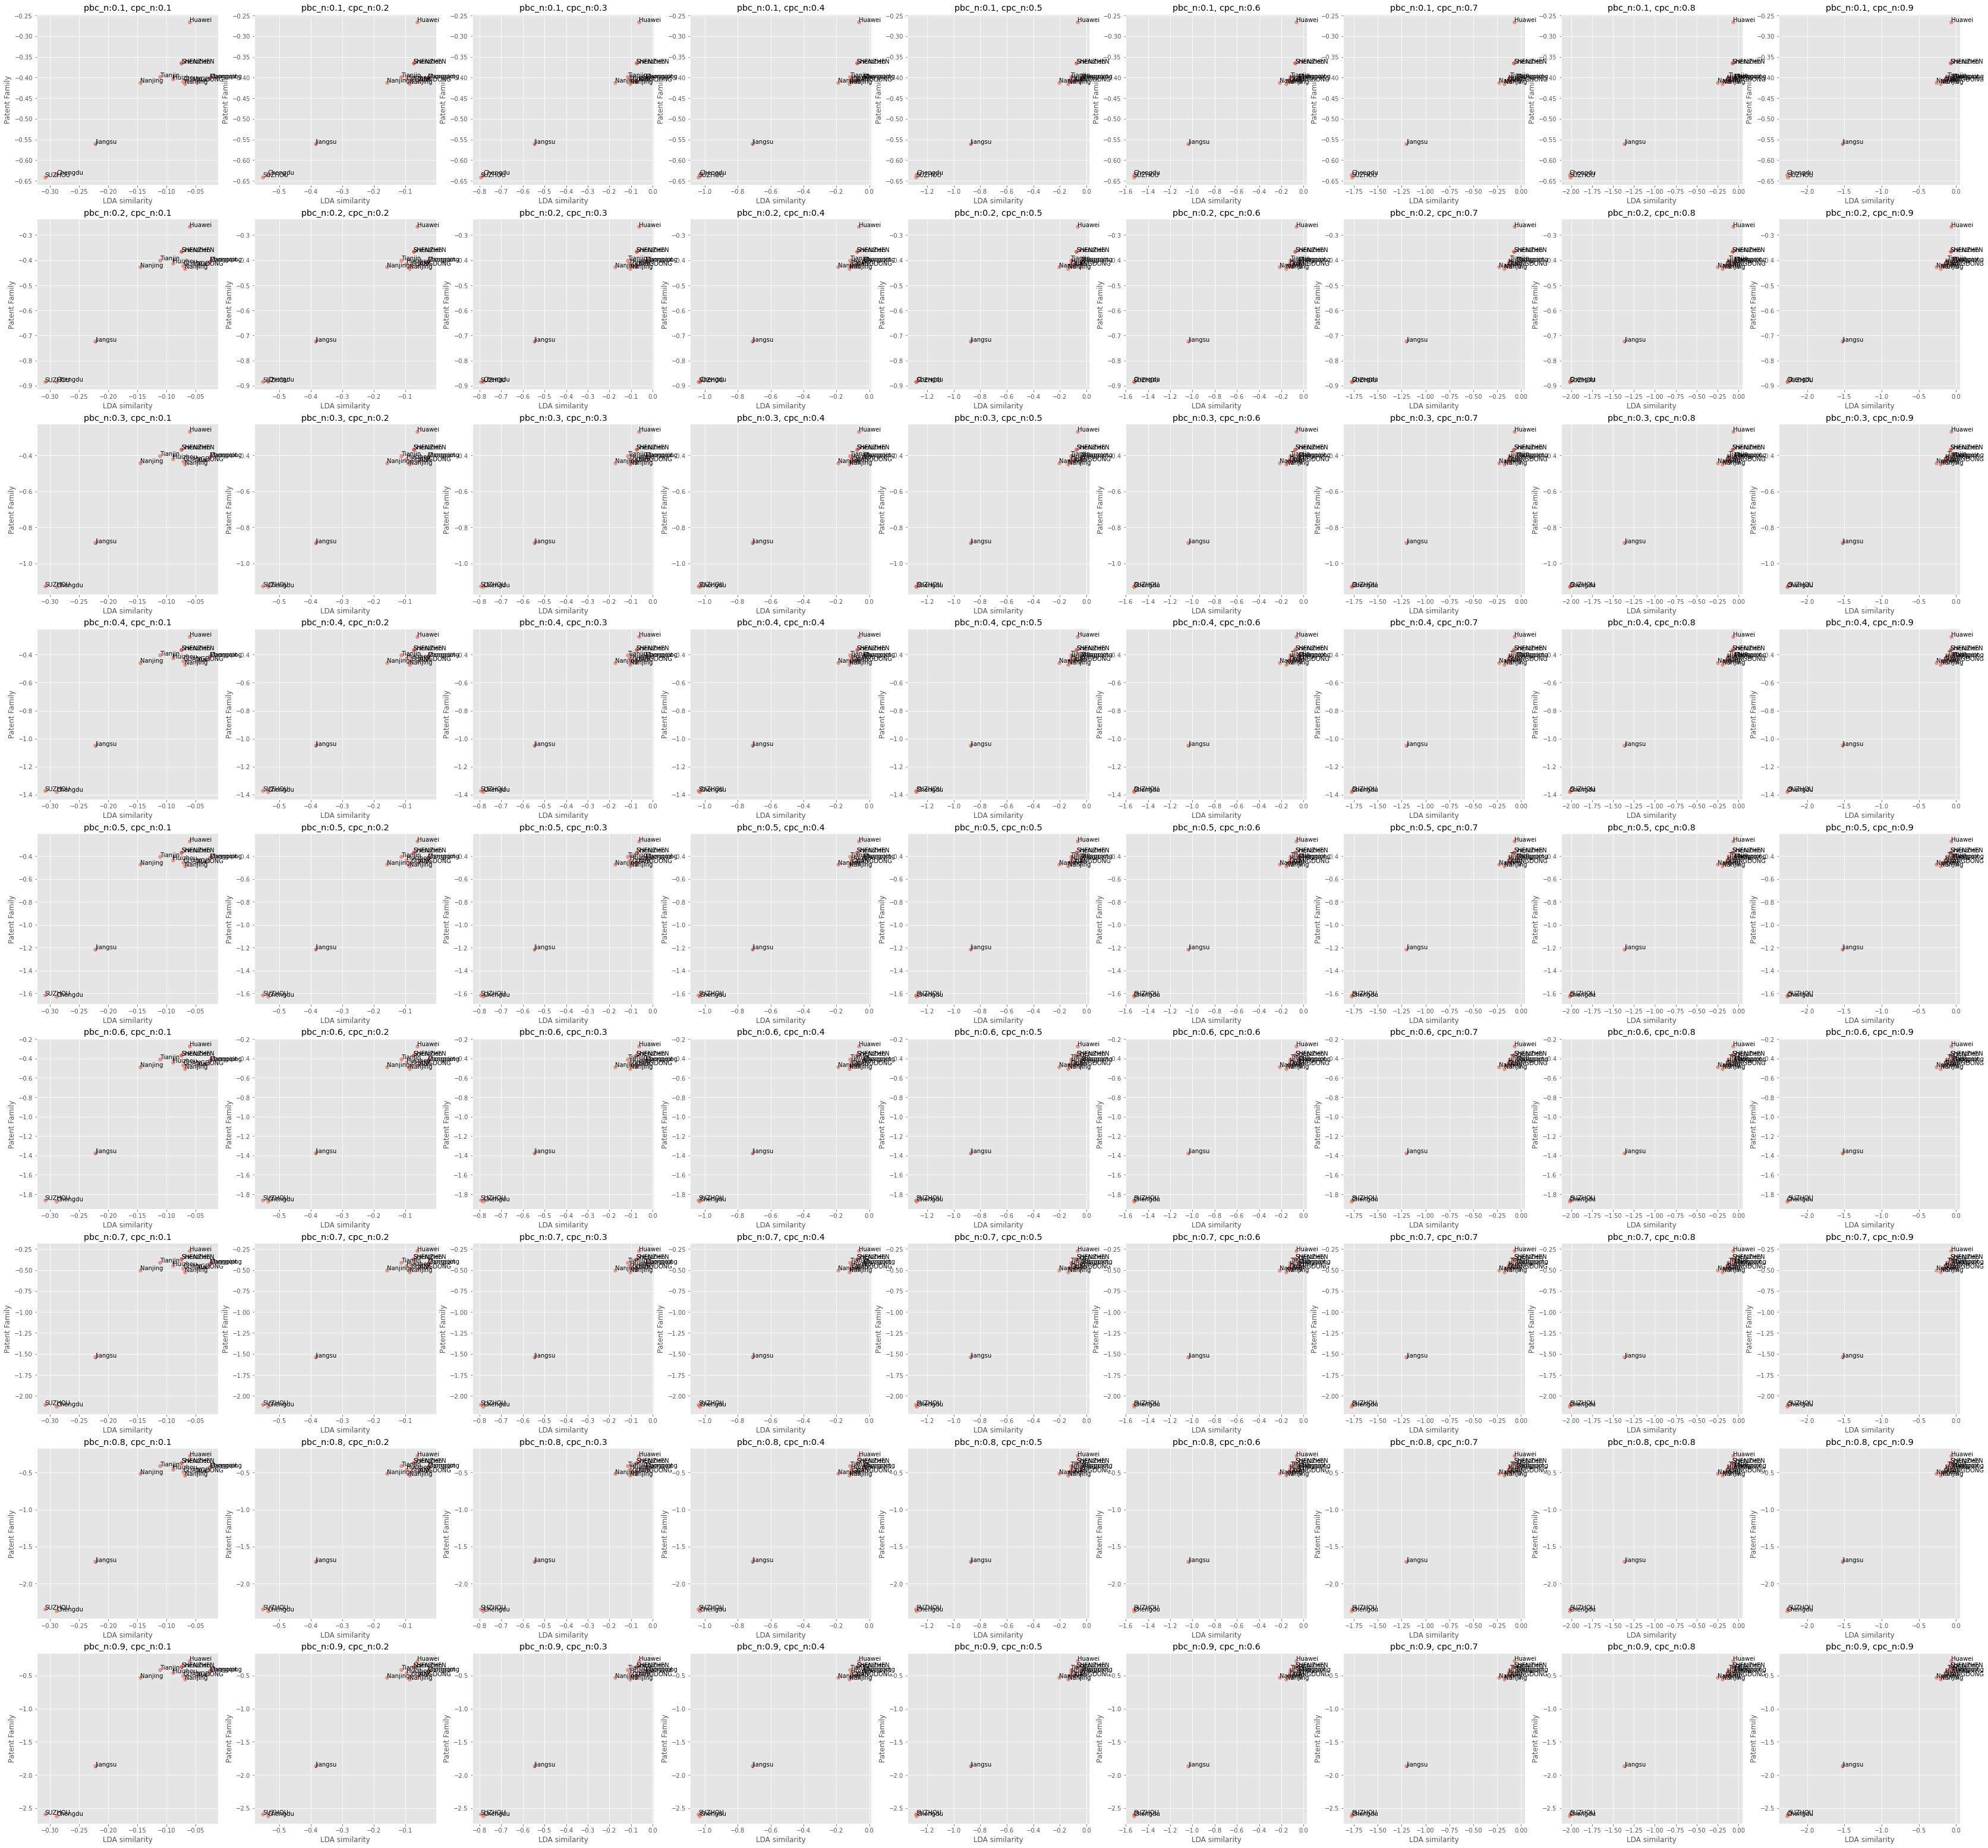

In [20]:
pbc_n_ls=np.arange(0.1,1,0.1)
cpc_n_ls=np.arange(0.1,1,0.1)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("LDA similarity")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_cn_brief_2015_1.png'.format(pbc_n))

In [21]:
c_df

,cpc,country
company,,
Chengdu Qinchuan IoT Technology Co Ltd,2.269218,2.615872
SUZHOU XUANHE IOT TECHNOLOGY Co Ltd,2.258345,2.590770
Jiangsu IoT Research and Development Center,1.527998,1.866234
Nanjing Hansense Iot Technology Co Ltd,0.212247,0.559532
Nanjing IoT Sensor Technology Co Ltd,0.263274,0.530921
GUANGDONG ABEJ IOT INTELLIGENT TECHNOLOGY Co Ltd,0.165847,0.504082
Huawei Technologies Co Ltd,0.069958,0.275140
SHENZHEN QIANHAI LINGJU INTERNET OF THINGS SCIENCE & TECHNOLOGY Co Ltd,0.076837,0.367859
Shenzhen Qianhai Livall IoT Technology Co Ltd,0.076837,0.367859


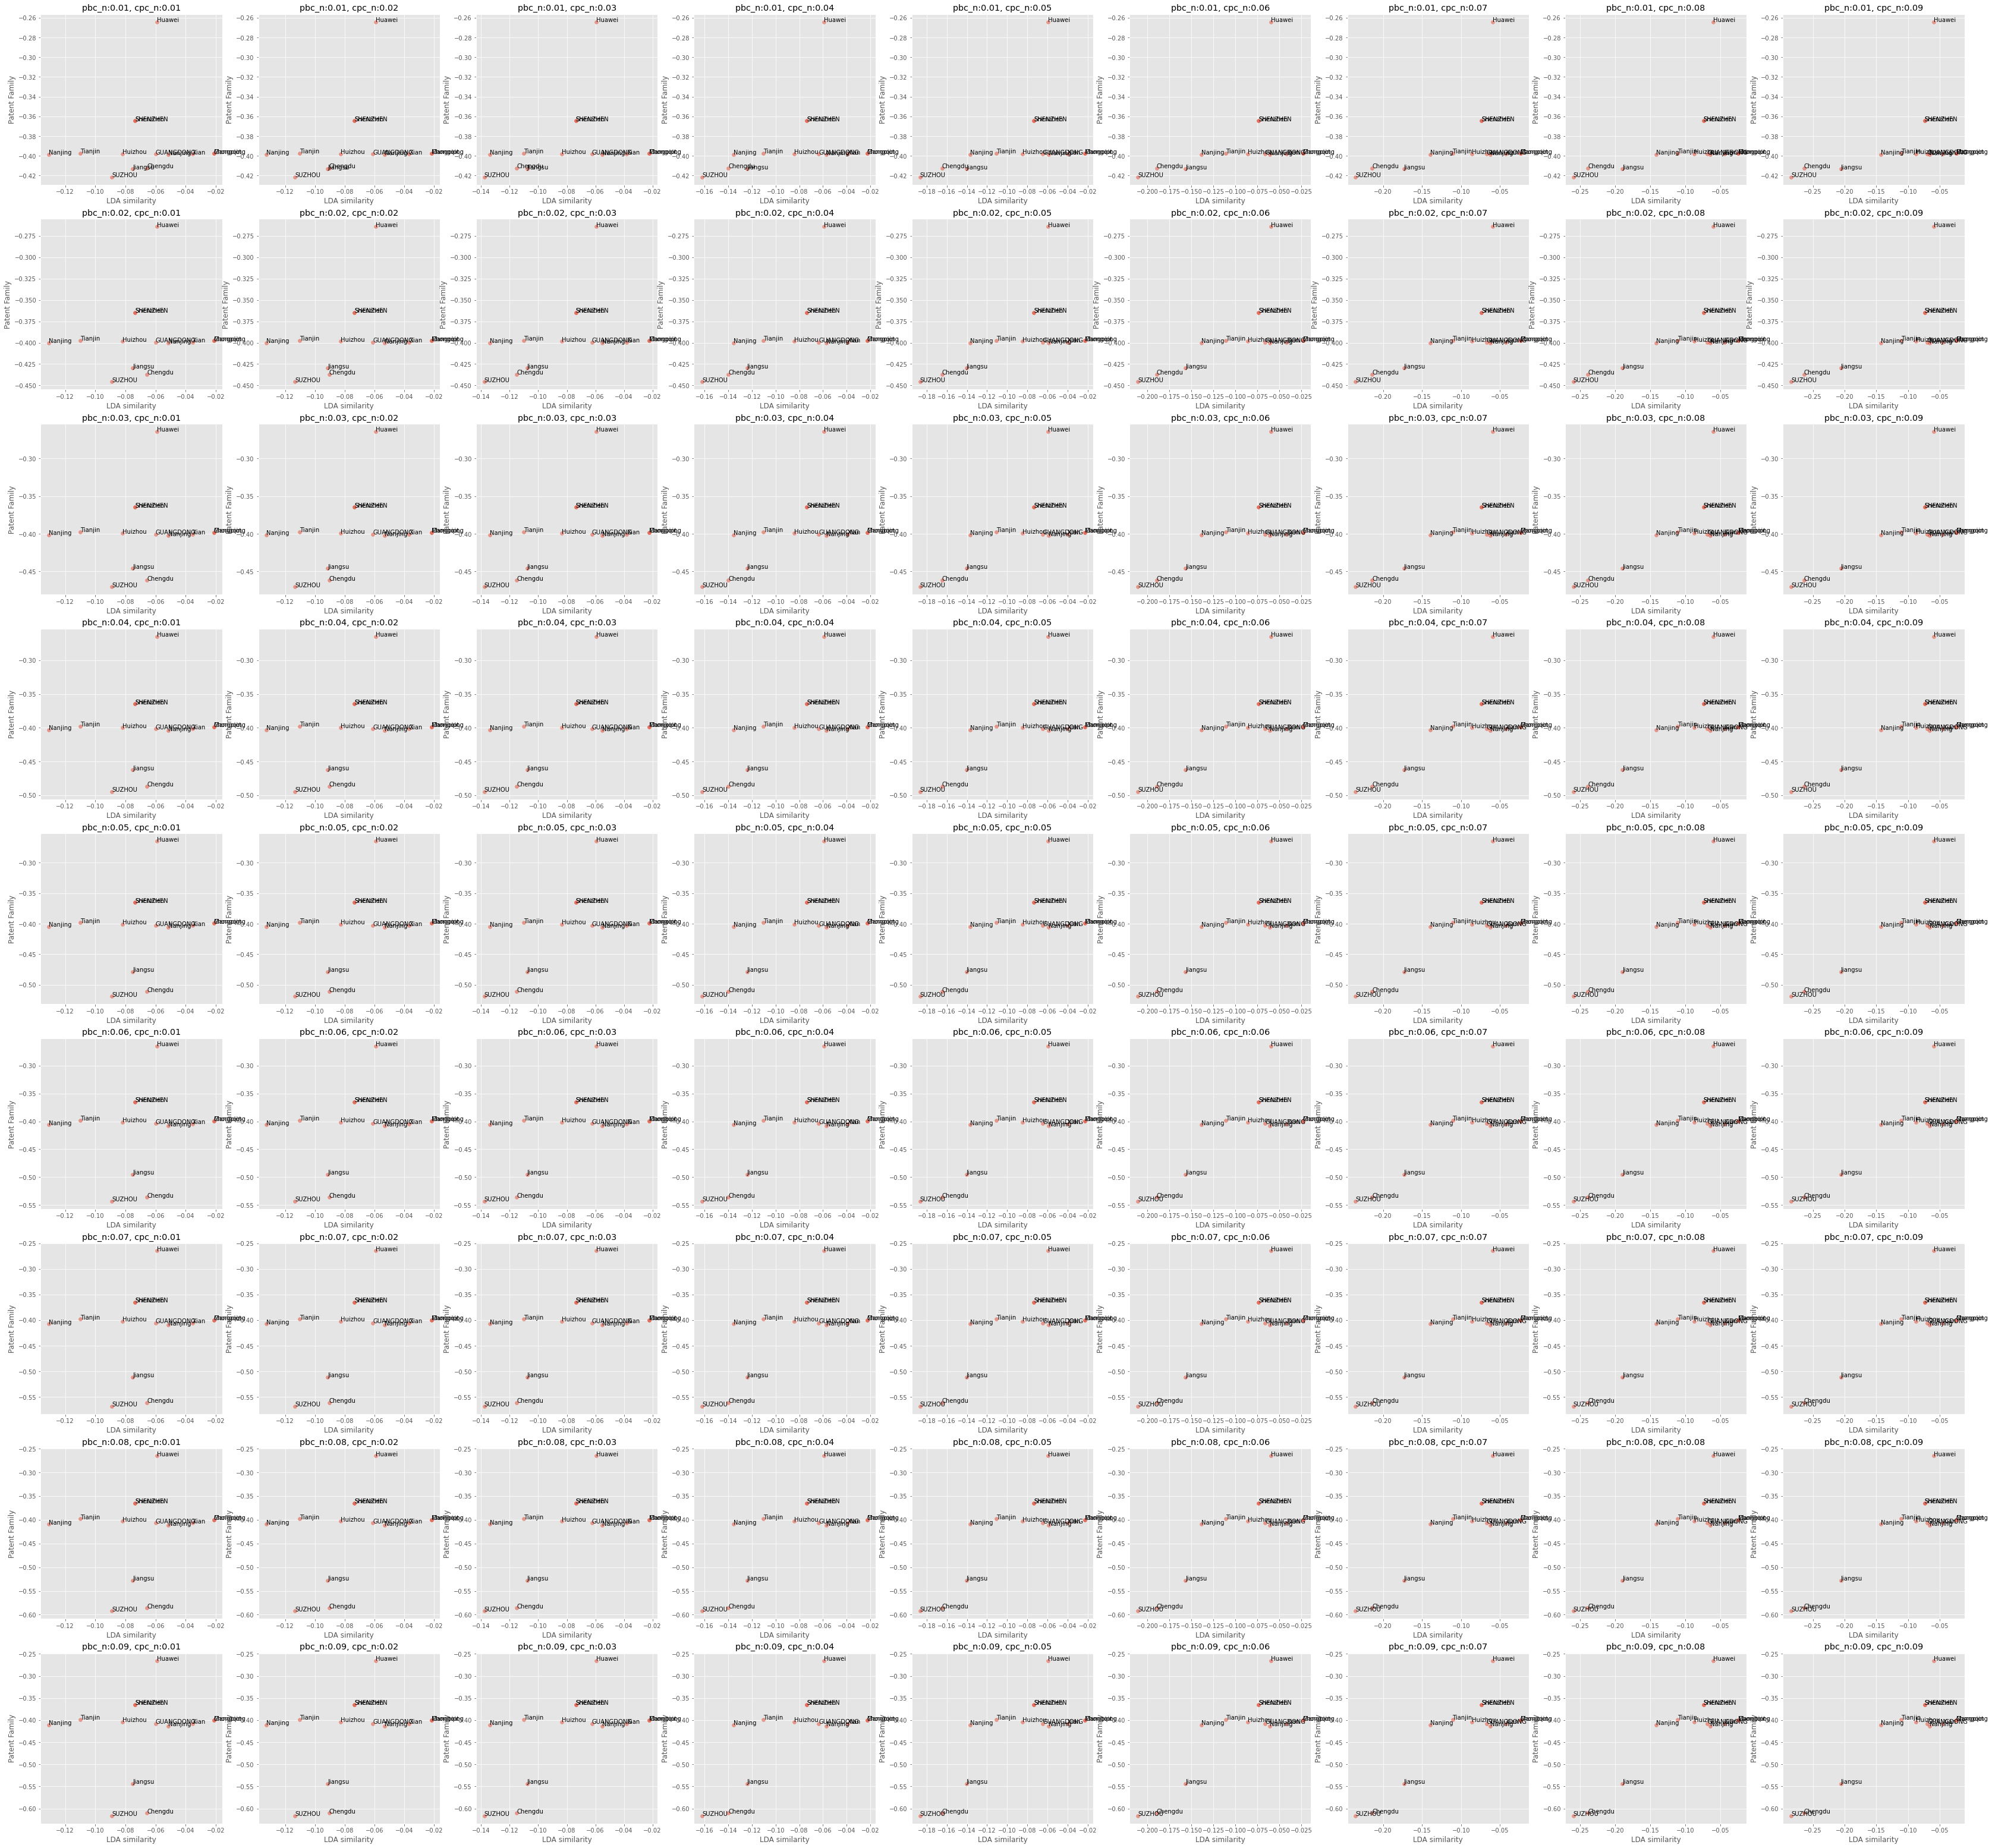

In [22]:
pbc_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("LDA similarity")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_cn_brief_2015_2.png'.format(pbc_n))

In [23]:
c_df

,cpc,country
company,,
Chengdu Qinchuan IoT Technology Co Ltd,0.263722,0.610376
SUZHOU XUANHE IOT TECHNOLOGY Co Ltd,0.284004,0.616430
Jiangsu IoT Research and Development Center,0.205741,0.543976
Nanjing Hansense Iot Technology Co Ltd,0.066021,0.413306
Nanjing IoT Sensor Technology Co Ltd,0.142798,0.410445
GUANGDONG ABEJ IOT INTELLIGENT TECHNOLOGY Co Ltd,0.069526,0.407761
Huawei Technologies Co Ltd,0.059937,0.265119
SHENZHEN QIANHAI LINGJU INTERNET OF THINGS SCIENCE & TECHNOLOGY Co Ltd,0.073860,0.364882
Shenzhen Qianhai Livall IoT Technology Co Ltd,0.073860,0.364882


In [24]:
c_df = scatter_plot(pbc_n,cpc_n)
c_df = c_df.reset_index()
c_df["company"] = c_df.company.apply(lambda x: x.replace(" Inc","")\
                                                    .replace(" Co Ltd","")\
                                                    .replace(" Co. Ltd.","")\
                                                    .replace(" Co., Ltd.","")\
                                                    .replace(" Ltd","")\
                                                    .replace(" Corp","")\
                                                    .replace("..","")\
                                                    .replace("International Business Machines","IBM")\
                                                    .replace("Nippon Telegraph and Telephone","Nippon Telegraph & Tel")\
                                                    .replace("Alibaba Group Holding Ltd","Alibaba")\
                                                    .replace("ZTE Intelligent IoT Technology","ZTE")\
                                                    .replace("AT&T Intellectual Property I LP","AT&T")\
                                                    .replace("Microsoft Technology Licensing LLC","Microsoft")\
                                                    .replace("Telefonaktiebolaget LM Ericsson AB","Ericsson")\
                                                    .replace("Cisco Technology","Cisco Systems")\
                                                    .replace("Verizon Patent and Licensing","Verizon Communications")\
                                                    .replace("Nokia Technologies Oy","Nokia")\
                                                    .replace("China Mobile Communications Group","China Mobile")\
                                                    .replace("Nokia Solutions and Networks Oy","Nokia")\
                                                    .replace("China Mobile","China_Mobile")\
                                                    .replace("China Mobile IoT","China_Mobile_IoT")\
                                                    .replace("China United Network Communications Group","China_Unicom")\
                                                    .replace("Shanghai Langbo Communication Technology","Shanghai_Langbo")\
                                                    .replace("State Grid of China SGCC","SGCC")\
                                                    .replace("Beijing Sankuai Online Technology","Beijing_Sankuai")\
                                                    .replace("Beijing Xiaomi Mobile Software","Xiaomi")\
                                                    .replace("Guangdong Oppo Mobile Telecommunications","Oppo")\
                                                    .replace("Shanghai Roye Electric Science and Technology","Shanghai_Roye_Electric")\
                                                    .replace("Xian Irain IoT Technology Servic","Xian_Irain")\
                                                    .replace("China University of Geosciences","CUG")\
                                                    .replace("Shenzhen Shenglu IoT Communication Technology","Shenglu")\
                                                    .replace("Chengdu Qinchuan IoT Technology","Qinchuan_IoT")\
                                                    .replace("Hangzhou Wopu IoT Technology","Wopu_IoT")\
                                                    .replace("Huaway IoT Technology","Huaway_IoT")\
                                                    .replace("HUIZHOU TECHZEN IOT SCIENCE & TECHNOLOGY","HUIZHOU_TECHZEN_IOT")\
                                                    .replace("Anhui Sharetronic Iot Technology","Anhui_Sharetronic")\
                                                    .replace("Nanjing IoT Sensor Technology","Nanjing_IoT")\
                                                    .replace("SUZHOU XUANHE IOT TECHNOLOGY","SUZHOU_XUANHE_IOT")\
                                                    .replace("Jiangsu IoT Research and Development Center","Jiangsu_IoT")\
                                                    .replace("Shenzhen JBT Smart Lighting","JBT_Smart_Lighting")\
                                                    .replace("Shenzhen Mayixiongbing Iot Technology","Mayixiongbing_IoT")\
                                                    .replace("SHENZHEN QIANHAI LINGJU INTERNET OF THINGS SCIENCE & TECHNOLOGY","QIANHAI_LINGJU")\
                                                    .replace("Shenzhen Qianhai Livall IoT Technology","Livall")\
                                                    .replace("Nanjing Hansense Iot Technology","Hansense_IOT")\
                                                    .replace("GUANGDONG ABEJ IOT INTELLIGENT TECHNOLOGY","ABEJ_IOT")\
                                                    .replace("Tianjin Hui Zhiwulian Science And Technology","THZST")\
                                                    .replace("Chongqing Liuhe Iot","Chongqing_Liuhe_IOT")\
                                                    .replace("Huizhou Sanhe Iot Technology","Huizhou_Sanhe_IOT"))
c_df.set_index("company", inplace=True)
c_df = c_df.drop("Samsung Electronics")

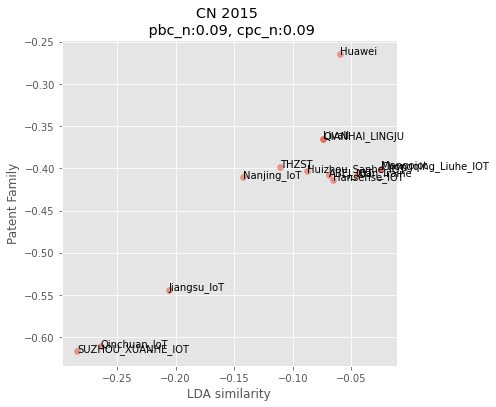

In [25]:
pbc_n=0.09
cpc_n=0.09
# c_df = scatter_plot(pbc_n,cpc_n)
# c_df = c_df.drop("Samsung Electronics Co Ltd")

plt.figure(figsize=(6,6))
plt.style.use('ggplot')
#plot
# plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
plt.title("CN 2015 \n pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
plt.xlabel("LDA similarity")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

In [26]:
m_x = (-max(c_df.cpc)-min(c_df.cpc))/2
m_y = (-max(c_df.country)-min(c_df.country))/2

competitor_ls = []

for i,cpc,con in zip(c_df.index,c_df["cpc"],c_df["country"]):
    if -cpc>m_x and -con>m_y:
        competitor_ls.append(1)
    elif -cpc<m_x and -con>m_y:
        competitor_ls.append(2)
    elif -cpc>m_x and -con<m_y:
        competitor_ls.append(3)
    else:
        competitor_ls.append(4)

In [27]:
competitor_ls

[4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [28]:
c_df

,cpc,country
company,,
Qinchuan_IoT,0.263722,0.610376
SUZHOU_XUANHE_IOT,0.284004,0.616430
Jiangsu_IoT,0.205741,0.543976
Hansense_IOT,0.066021,0.413306
Nanjing_IoT,0.142798,0.410445
ABEJ_IOT,0.069526,0.407761
Huawei Technologies,0.059937,0.265119
QIANHAI_LINGJU,0.073860,0.364882
Livall,0.073860,0.364882


In [29]:
c_df.to_csv("competitor_df/company/lda_cn_2015.csv")